- Tutorial link: https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html
- Evidence Lower Bound (ELBO), KL divergence proof: https://jaketae.github.io/study/elbo/
- Denoising Diffusion Probabilistic Models: https://arxiv.org/pdf/2006.11239

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm import trange

# Forward Process

$$q(x_{1:T} | x_0) = \prod_{t=0}^T q(x_t | x_{t-1}), $$ 
$$\text{where} \quad q(x_t | x_{t-1}) := \mathcal{N}\left(x_t | \sqrt(1-\beta_t) x_{t-1}; \beta_t I\right)$$

$q(x_{1:T})$ means the joint distribution of $x_1, x_2, x_3, ... x_T$. It is the same as $q(x_1, x_2, x_3, ... x_T)$.$\beta_t$ could be chosen manually or learnt by the network. Assume we choose values such as $0 < \beta_t < 1$, we can prove that the final distribution after many iterations $q(x_T) \sim \mathcal{N}(0, I)$.  Note that we iteratively add noise to the original distribution. From step $t=1$ onwards, the noise comes from two parts:
- A shrinking of the previous step's value $x_{t-1}$ by $\sqrt(1-\beta_t)$, which means the variance from previous steps gets scaled by $\sqrt(1-\beta_t)$.
- Addition of new independent noise with variance $\beta_t I$.



The following is a sketch of proof.
- For means, $\lim_{N\to\infty} \mu_N = \lim_{N\to\infty} \left(\sqrt{1-\beta_t}\right)^N = 0$
- For variance, consider:
    - $\sigma_0^2 = 0$
    - $\sigma_1^2 = \beta_1$
    - $\sigma_2^2 = (1-\beta_2)\beta_1I + \beta_2I = \left[ 1 - (1-\beta_1)(1-\beta_2) \right]I$.
    - $\sigma_3^2 = \left[ 1 - (1-\beta_1)(1-\beta_2) \right] (1-\beta_3)I + \beta_3I = \left[ 1 - (1-\beta_1)(1-\beta_2)(1-\beta_3) \right]I$
    - Therefore, $\sigma_N^2 = (1 - \bar{\alpha}_N) I$, where $\bar{\alpha}_N = \prod_{s=1}^t (1 - \beta_s)$. Now for very large $N$,  $\lim_{N\to\infty}\sigma_N^2 = 0$
    
# Reverse Process
The idea is to sample a $x_T$ from a zero-mean unit-variance Gassian distribution and use the learnt Neural Network to recover the $x_0$. We want to maximize the likelihood of observing the original input $x_0$, $\textit{i.e.}, \text{max} E\left[ p_\theta(x_0) \right]$. This is equivalent to minimizing the negative log likelihood of $x_0$ under the predicted distribution parameterized by $\theta$, $\textit{i.e.}, \text{min} E\left[- log p_\theta(x_0) \right]$

$$\begin{aligned}
\log\left( p(x) \right) &= \log\left( \int p(x, h) \, dh \right) \\
                               &= \log\left( \int q(h|x) \frac{p(x, h}{q(h|x)} dh \right) \\
                               &= \log\left( E_q \left[ \frac{p(x, h)}{q(h|x)} \right] \right) \\
                               &\geq E_q\left( \log \left[ \frac{p(x, h)}{q(h|x)} \right] \right)
\end{aligned}$$

The above equation shows how to compute the Evidence Lower Bound (ELBO) or Variational Lower Bound for $\log\left( p_\theta(x) \right)$. The last inequality is called **Jensen's inequality** which states that for convex function $f$, $E\left[ f(x) \right] \geq f\left( E(x) \right)$. $\log$ is a concave function, so we reverse the sign. Let's apply the result to the diffusion model.

$$\begin{aligned}
-\log\left( p_\theta(x) \right) &\geq E_q\left( \log \left[ \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)} \right] \right) \\
                                &= E_q \left[ -\log p_\theta(x_{0:T}) + \log q(x_{1:T} | x_0 ) \right] \\
                                &= E_q \left[ -\log \left(p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1}|x_t) \right) + \log q(x_{1:T}|x_0) \right] \\
                                &= E_q \left[ -\log \left(p_\theta(x_T)\right) - \sum_{t=1}^T  \log p_\theta(x_{t-1}|x_t) + \log q(x_{1:T}|x_0) \right] \\
                                &= E_q \left[ -\log \left(p_\theta(x_T)\right) - \sum_{t=1}^T \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t | x_{t-1})} \right]
\end{aligned}$$

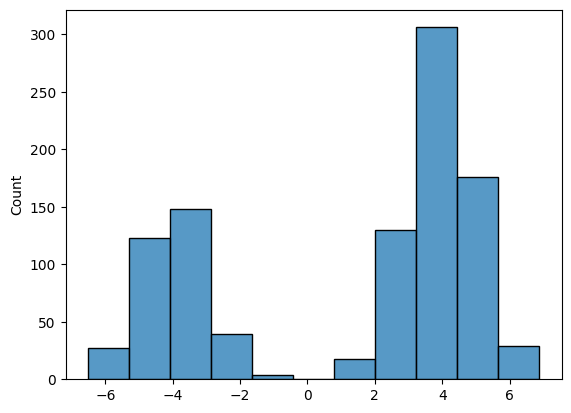

In [2]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])), # defines the mixing weights (probabilities) --> twice likely to pick RV from the 2nd distribution than the 1st one
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.])) # N1(-4, 1), N2(4, 1)
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0])
plt.show()

In [3]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02

In [4]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion following equation 2
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        )
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [5]:
_, samples = do_diffusion(dataset)

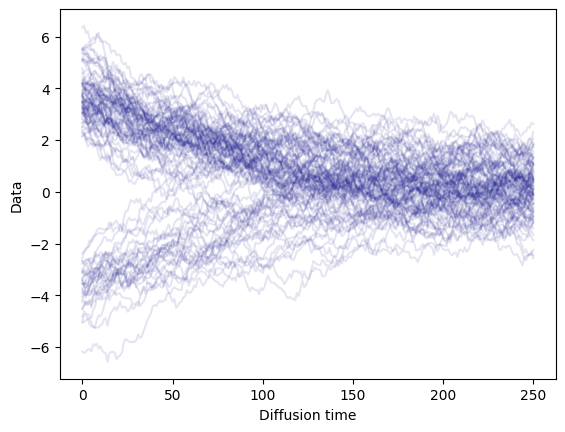

In [22]:
for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t, c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

In [36]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    p = torch.distributions.Normal(
        torch.zeros(forward_samples[0].shape),
        torch.ones(forward_samples[0].shape)
    )
    loss = -p.log_prob(forward_samples[-1]).mean() # pdf value of p evaluate at forward_samples[-1] --> how likely is it to observe x_T in unit Gaussian distribution p

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1
        )
        # compute p( x(t-1) | x(t) ) as equation 1
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.Normal(mu, sigma)

        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))

    return loss / len(forward_samples)

In [37]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1), torch.nn.Softplus()
)

In [38]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2, weight_decay=1e-6,
)

In [42]:
loss_history = []
for e in trange(1000):
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(
        forward_distributions, forward_samples, mean_model, var_model
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]


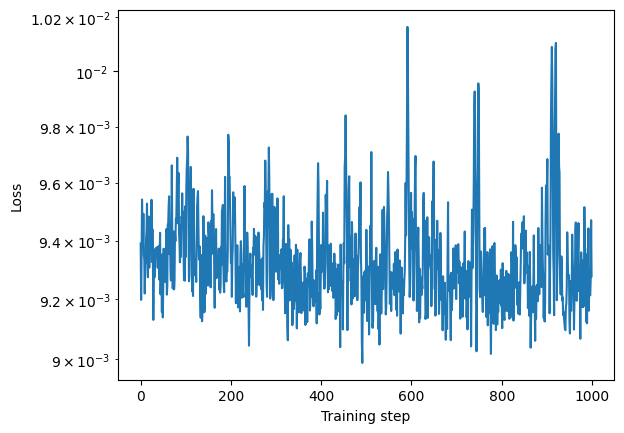

In [43]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [44]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

In [45]:
samps = torch.stack(sample_reverse(mean_model, var_model, 1000))

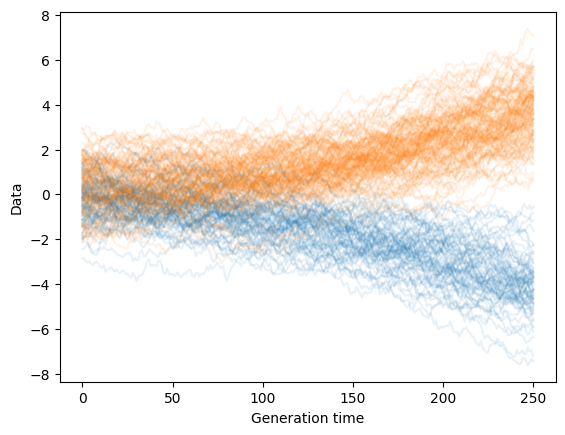

In [46]:
for t in samps[:,:,0].T[:200]:
    plt.plot(t, c='C%d' % int(t[-1] > 0), alpha=0.1)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

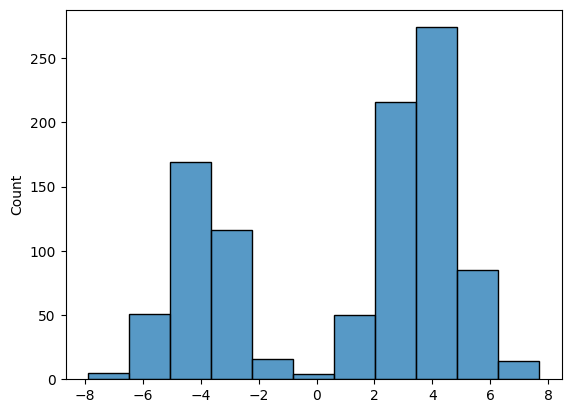

In [47]:
sns.histplot(samps[-1, :, 0])
plt.show()